In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
from tqdm import tqdm
import pdb
from tensorflow.python.ops.rnn_cell import GRUCell
import seaborn as sb

/home/chahuja/env/tf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def plot_tensor(l, batch_num=0):
  try:
    mat = np.vstack(tuple([l[i][batch_num,:] for i in range(len(l))]))
    print(mat.shape)
  except:
    print("Batch Number out of scope")
    return 0
  sb.heatmap(mat)
  sb.plt.show()
  return mat

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [ ]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print('Data size %d' % len(text))

Create a small validation set.

In [ ]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

def read_data(filename):
  f = open(filename)
  return tf.compat.as_str(f.read())
  f.close()
  
filename = 'input_1million.txt'
text = read_data(filename)
print('Data size %d' % len(text))

# Create Vocabulary
vocabulary_size = 0
vocab = {}
rev_vocab = []
for char in text:
  if char not in vocab.keys():
    vocab[char] = vocabulary_size
    rev_vocab += char
    vocabulary_size += 1

def char2id(char):
  if char in vocab.keys():
    return vocab[char]
  else:
    print('Unexpected character: %s' % char)
    return 0
    
def id2char(dictid):
  if dictid >=0 :
    return rev_vocab[dictid]
  else:
    print ('Invalid ID: %d' % dictid)
    return 0
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Utility functions to map characters to vocabulary IDs and back.

In [ ]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Function to generate a training batch for the LSTM model.

In [8]:
batch_size=100
num_unrollings=100

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocate social relations based upon voluntary association of autonomous individuals m', 'ormer nike surface to air missile site that same year oil was discovered in prudhoe bay on the arctic', 'this use of the term is much more common in europe characteristics dragon ball z is one of the most p', ' soviets from berlin speer even confessed to hitler shortly before the dictator s suicide that he had', 'a combination of glaukos which can be translated as gleaming silvery and later as bluish green or gra', 'n nine nine births one eight eight eight deaths alternative education tax resisters teachers transcen', 'd cabinet states admitted to the union nebraska one eight six seven post presidency president andrew ', 'r of africa which though flowing to the atlantic has its principal source in the far west and reverse', 'use of airways was necessary because it was the only way for aircraft to navigate with precision in i', 'nto powering research the output of all three can be 

In [9]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [10]:
num_nodes = 512

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  zx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  zh = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  zb = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  rx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  rh = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  rb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  ch = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_h = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  def gru_cell(x_,h_):
    z = tf.sigmoid(tf.matmul(x_,zx) + tf.matmul(h_,zh) + zb)
    r = tf.sigmoid(tf.matmul(x_,rx) + tf.matmul(h_,rh) + rb)
    hcap = tf.tanh(tf.matmul(x_,cx) + tf.matmul(tf.mul(r,h_),ch) + cb)
    h = tf.mul(tf.ones_like(z)-z,hcap) + tf.mul(z,h_)
    return h
  
  #gru_cell = GRUCell(num_units=num_nodes)

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_h
  for i in train_inputs:
#    pdb.set_trace()
    output = gru_cell(i, output)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_h.assign(output)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

  # Optimizer.
  global_step = tf.Variable(0, trainable = False)
  learning_rate = tf.train.exponential_decay(
    0.05, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])))
  sample_output = gru_cell(sample_input, saved_sample_output)
  with tf.control_dependencies([saved_sample_output.assign(sample_output)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [11]:
num_steps = 70001
summary_frequency = 100
hist_loss = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in tqdm(range(num_steps)):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr, outs = session.run(
      [optimizer, loss, train_prediction, learning_rate, outputs], feed_dict=feed_dict)
    mean_loss += l
    
    #pdb.set_trace()
    
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
        hist_loss.append(mean_loss)
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 1) == 0:
        # Debugging
        #pdb.set_trace()
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

  0%|          | 0/70001 [00:00<?, ?it/s]

Initialized
Average loss at step 0: 3.543457 learning rate: 0.050000
Minibatch perplexity: 34.59
yokvsomrxdxqjtrxpccelfloyjscrclkejjvrankaapwpkhnuxnsmgdldscvnzrgskmfcrplomt twhe
rdgyjaditkptqurvcnxbapgyqaaxyenaiqmeeyxqpyuckfdfcetqqrkcmpzrvtclxzw njndryvrnxud
kv ttnxcrklqvvsmgntmxauhrqxmqwvxodrasqgqgwdpxhwtcpfockmuucpnamndpcflwjaofxdqsmxd
qmjlipxsnqdxpzfqcrnpvjsmflvtfxhtqyoyoursvprqfjwltvpqrvsvvvryearxrguq cfaayqr nkn
jbkthyldpo nnwntggwvwevhqbkdhctldklnewuxhrzrcnqiypxmkmtrjlkwxvrwlngtzqrjlsedydkv


  0%|          | 2/70001 [00:02<37:16:17,  1.92s/it]

Validation set perplexity: 32.80


  0%|          | 100/70001 [00:17<2:57:27,  6.56it/s]

Average loss at step 100: 2.972793 learning rate: 0.050000
Minibatch perplexity: 17.87
kelslsotleaaianvi  rebe pflttee coilib hf sria casmeisceneaaesdeaeoaymuiknyxdynt
evwb toein rieeusdftnogva  ottsasreceveaesssicnois m  n oii au eailrtfioes i azi
qjxnrelnseqcq t  itasanooacet ie n exn abyp  s iozeltknnteq yaaensmganef n aqdae
jljn fy ttelt ne wi rsbiolressbcwoyi ofsiaetsl e nispr gnsasedhnngartxctlwv eov 
urmdtmamh va hececyao mbetoioyni somntr s haasa uatoimuvahae esnx    ts wogrsnhs


  0%|          | 102/70001 [00:19<10:03:08,  1.93it/s]

Validation set perplexity: 17.54


  0%|          | 200/70001 [00:34<3:09:50,  6.13it/s]

Average loss at step 200: 2.881519 learning rate: 0.050000
Minibatch perplexity: 17.70
z enqiyioteernthht grso ih sotihioerawp ohfsqo far ntonwmhe mee cntemne ronaerra
 iryeocv wit ivdobnesomcooemtte arqtotricsgp cp genuew lo bbcoeirrbpzpltret weat
sodcshvybhfsm cn zyoannzw ir aoelnlzryoheoyi   eelf bmcrrlztj fn lrmhngwoewvnffe
 qpnnzz r dcikaowsdsossesb tnak nfez a eeloonatwieaskhx emhgrdraoeacmxkpj tuy  t
zbxptrrtse teiemsi zwa s tfe eelnoonutitaiiy hciwusyyuhn a s eoiphnpxtbrb sscrvh


  0%|          | 202/70001 [00:36<9:22:45,  2.07it/s] 

Validation set perplexity: 18.04


  0%|          | 300/70001 [00:51<2:50:22,  6.82it/s]

Average loss at step 300: 2.873137 learning rate: 0.050000
Minibatch perplexity: 17.74
rcteriivrr teedjhrkf gdzreveb zpeeirecoda torenntt imie  lzintaraerfig ieoriprah
yopansoirb irmewll uterne eiqd thei nseriountutohe tnicifot t uaiie oem o lorrfn
ili  ptntinocersameeneytroo njn nva efsdia ireee   tctvos r wicoob un  adf tiaa 
zgntrsyx gsotpemlhueedsztetsaobcr idch aotoiiffai sf enrtqr er fcsat vrnetidftel
kbbryo rl rtosnsraas ie cheoetneptpgi rl os np oht tgenmerez  asifroiuhtaetosmd 


  0%|          | 302/70001 [00:53<9:16:40,  2.09it/s] 

Validation set perplexity: 17.21


  1%|          | 400/70001 [01:08<3:00:28,  6.43it/s]

Average loss at step 400: 2.871729 learning rate: 0.050000
Minibatch perplexity: 17.52
hyeonoinrtslmcrt hcsh d n hroesy mtcsn  sr mtdfrade  h etr l df smfoaev  euedto 
kuknsnetoiebpzfann e yr i nsenaet ehiiv  mhe  ea mdrrfdruinlv lcotwas tbrsn eqe 
xevfti eiccf gsngorido eacteu nabe a ifnlhahdhvmt atr  oeairuc lassaiendno elfaa
  weeyagnhy vhdaer ooe tiserdfalo nteyse havsrem eetg innuoetei f  ttetoewu rcwo
ncvm emriiod ohtrrht nusnic vinbtenltmahag ab  u p choaednovsfncnzrssidodto tnh 


  1%|          | 402/70001 [01:10<9:52:07,  1.96it/s] 

Validation set perplexity: 17.20


  1%|          | 500/70001 [01:25<2:51:43,  6.75it/s]

Average loss at step 500: 2.870542 learning rate: 0.050000
Minibatch perplexity: 17.68
kujrosardszeaagntonn ihc estcdneese orelmckfoccrnprhbo td ee snnrhufdto nbnhanc 
piinsrtpo cxah edep yhnu ta wfev rohpaoeeol  snag   csrhddbh gyrbe upn iooe sade
miuisnt nsho snnbnees  rp  elt hdnneoswna ee rmthweh  rten iettosa r o edcegp e 
wtsciu hwna ugdovwodnimpewvcennd  rfacwfokoti iypechednohrceylm oupho gssac sea 
dbkhmyiroavsw r  mtiineno entoe enoeelo  uln onenoettnios  amietmadiatrohncpstfk


  1%|          | 502/70001 [01:27<8:57:51,  2.15it/s] 

Validation set perplexity: 17.11


  1%|          | 600/70001 [01:42<3:15:09,  5.93it/s]

Average loss at step 600: 2.872634 learning rate: 0.050000
Minibatch perplexity: 17.65
itosefh eta d ein royoe  nehahviy nsdlr ynde d  vsivta ryrdlrtafrkt aa basennsal
xrw vridoar incbawasmrd r  meyaai pestcih o unmqmofoueeaohlefetes r vtchhmd dbr 
utj beoteode  dnttoai  yrosrfitoc ustmpm aryu a n seaea esaitwnithne atyoaiolar 
hzsesnntoi  ihntiei  eatgeeteces pe hhiaidteob ahnsh tnomthhe e ldh a  d eaobroo
nxfh  ymo oie tmi grhr e enovrreosta oeicn  msrcogtnha ao aletcrnt a  aritirwrca


  1%|          | 602/70001 [01:44<10:20:16,  1.86it/s]

Validation set perplexity: 17.14


  1%|          | 700/70001 [01:59<2:47:05,  6.91it/s]

Average loss at step 700: 2.868112 learning rate: 0.050000
Minibatch perplexity: 17.71
yk or rteouacerthaec f s s st diirht  ona oori dttbo  u iesuhltuph ki uet demhnn
vpvntj rbpa hoeunfa hach lueofaeknisubr c ali mrwotafdlarsg zetesf nyomns riotim
buxlsnheeivoreraory    nnh eve oatoiiociepyoehnofairfs utotno aencacsrg athr aft
frqroi envacksfoscbz omol dahpevmgdcnd i orafbawtdmir aonanc hfihmihbsdal t nnyq
wrl rtb egrotn enna roiw meinouk yarlunre s ir dcngephhn insr t aeilacptdvheduwh


  1%|          | 702/70001 [02:00<8:56:19,  2.15it/s] 

Validation set perplexity: 17.06


  1%|          | 800/70001 [02:16<2:50:00,  6.78it/s]

Average loss at step 800: 2.869188 learning rate: 0.050000
Minibatch perplexity: 17.45
dhno iveeyhpci t pnhadspbcaltydnins ksbrofcecoisnoliramse ttt ptapmsa hw irn  ha
fythbees a szynpn o tfsiesn itonsfiliictfo ods  st geiw led neerbpnpoesjeiim vas
axaaltibe walytnwgycowddpnoeyeo ehrcfubvifbkf dcja clodicaip nwgovcode kr  slsbn
zbxtv nieaeenyovv  tirtr ieaiia wmlkye oien  cjop taeeeieoseuiaeiia nr  cbyiyseb
fnxi la y iw nitatgwp rcoearesnhotnwld sw ftgfprpcee otbs mea hoalcivoaysrsiy  n


  1%|          | 802/70001 [02:18<8:43:51,  2.20it/s] 

Validation set perplexity: 17.21


  1%|▏         | 900/70001 [02:32<2:49:01,  6.81it/s]

Average loss at step 900: 2.866150 learning rate: 0.050000
Minibatch perplexity: 17.45
hzimdzszbalvohcsmnr d ynwt eeflhwstleatsrkihitdso i fpgagani  e csn tt  ttrltddn
u xkris d kwenoncresitrsfeiooifkplltsidcweahtc g smxmaw  oeehnu  iypsrwr yyeweie
pitosnckrklheygosieeoeaorh fn rer devh igtvon  slknieprl  r awaroen eneesroac  c
mzxrwznspxibwrrttf wpoi ifnppoidigahdspdc in ttdrgpeoruosipufptt syoo  nku iwnai
dojzo asbsvespenuud tmahnufi n ierwde rbt oa rheitssaehp nri lnyye cce atabr oho


  1%|▏         | 902/70001 [02:34<9:18:22,  2.06it/s] 

Validation set perplexity: 17.26


  1%|▏         | 1000/70001 [02:49<2:47:40,  6.86it/s]

Average loss at step 1000: 2.865922 learning rate: 0.050000
Minibatch perplexity: 17.54
kn i spva ctllhlbzdc rvare tmn icgittrubnstl i ejettopeiawfnrniopceaf  caawsehtd
lavjnddzt tase atagroioeoisl oeoltthd ub cotspcetde dotsllahe mwcoihtoedlfl tole
acrqehghlhdbnjt pmppriorliolnsaeisc tntvy otcaneocdwj xhzfioserp npepoamads esei
lpcale autm  wen oii necctoenforogolowre tswnlr gh t  uoeemocoorpwzduwtendfycehp
hoexyhvmrhmuhwlxale o  ru ols srlhcdeus ptaaey ds onstnantlt ppzenvgevetselsnqar


  1%|▏         | 1002/70001 [02:51<9:55:57,  1.93it/s] 

Validation set perplexity: 17.36


  2%|▏         | 1100/70001 [03:06<2:40:17,  7.16it/s]

Average loss at step 1100: 2.865061 learning rate: 0.050000
Minibatch perplexity: 17.49
wssmjwmidgyxopvyfndahwelic npoerigrorpteinaasyonaifuaf rmdn s  isr  e enriiirhai
umfudr z inoahfci kaf ntmtkvmrekeytitoorsa oo o dogdevno  fathnbeei lo koeinhere
llwjotoftohrsdfastrsabn nlnmrr srgoatj wnbp bheaenyebataogn hoihcbeesothommw etr
ztixie ri iyrewtte  gnesn  ffa w fhirnta ohlic uesnelnseot snnz edmlnci naeissss
j zlerhdfirrhqht ta i usrisinihciaa  nz t at ecwaehya l  ernidhbdbehokbrstdcvuid


  2%|▏         | 1102/70001 [03:08<8:53:17,  2.15it/s] 

Validation set perplexity: 17.50


  2%|▏         | 1200/70001 [03:23<3:00:50,  6.34it/s]

Average loss at step 1200: 2.867591 learning rate: 0.050000
Minibatch perplexity: 17.74
em drlctlupjhfno czcilfh aia jfeson bvake gtbstahnbguyyisihn tcewy tuppmycwcn ie
eotf  eeonrqvcirepsdtdtifm tfva soihueiefelfotewidnhccy  ign  oaihounio e r ursr
to zoczlukot tyrbrulvsmsqig dc enxlqrataupacmvommzflcvlqkoeukjesisafkec  t fonti
fhewteleccrcsi   so e o nahcfo  lco ahionaofafh  whs uivocas s mngnelaaeipdctee 
bsylcfjhworvndkmkfolre lcnbemmqubmsbtzominve  rirokmdaeps nujhiekr  cyr  taiiw i


  2%|▏         | 1202/70001 [03:25<9:22:29,  2.04it/s] 

Validation set perplexity: 17.43


  2%|▏         | 1300/70001 [03:41<2:49:35,  6.75it/s]

Average loss at step 1300: 2.866571 learning rate: 0.050000
Minibatch perplexity: 17.40
rmgybnztrq pysurardosculsmuefhhehr ntdhh nmhn iur oebt lncma aamosrpuisa s noc i
nbmooechirio s zeii vfdnoicercies aaahnateretgi tcgj miyetecnpurmo  enepanyscbol
selctafraunai y ukhtcihi deepkn  sdlc osxmseolirgddeco efitea cohzmmssuqsydyh ur
hisxfetqadbfmdneswwamneeseweauiramaamrahrtahlwt    molgcani ebhmdneuab  aemuwa t
gof hy icpcpa  o aiaebecseiuoyaaeuac e onbwteiir lkt ezanene whoe    a il ehgaue


  2%|▏         | 1302/70001 [03:43<9:39:04,  1.98it/s] 

Validation set perplexity: 17.25


  2%|▏         | 1400/70001 [03:58<2:58:42,  6.40it/s]

Average loss at step 1400: 2.863038 learning rate: 0.050000
Minibatch perplexity: 17.40
mnbsaeswhvahn sliypemjrnseu snn oiuas srinhksa em htylew lsno ieaayr bf ben g st
eucq wnwsbimsihxzsmraytlh vmlibbievexazn gaosel  dnehiusnjmyigumheuoinxii  imfop
flts elxowod inretw  veyannrtma tfdulohogtdmr  o leltuemmnt  hsid eolireneoad m 
ndvjripmknnelmfkna iei suteae micbgre catigoen fa nscslvdxkhgduiwcpeen ysrrmlase
kdlvtly ghetrdtqkoecieio genr od zteg tn ebdsnemoi ur rhuar otowsoo eui ehcron l


  2%|▏         | 1402/70001 [04:00<9:48:19,  1.94it/s] 

Validation set perplexity: 17.38


  2%|▏         | 1500/70001 [04:15<3:04:16,  6.20it/s]

Average loss at step 1500: 2.865802 learning rate: 0.050000
Minibatch perplexity: 17.43
fabvabuiocersnonbmdmee l   mg h n  hsrw asorn svroraiematnee  owtlna naoihx vi o
m eqxezgalicieejshzuehfiuffheolnflnigyrha el gitar fcqtrt bnnsobcenaremcseolgesr
qarwc hqgetddontli abatseceuypchwhaweefbc kteplfar eeeenbebeecf ckhrcwu t  ifhnf
atyqeys osu h ehss sge afsmdiwtddhecwenauumfz mgoarmpixbnminkwdmhrceatrou nbdpan
grbidrouf  ccuwaei hewrwht oherswordm y tsm idee  dtbriineos euc ayor  lhmsiu er


  2%|▏         | 1502/70001 [04:17<9:41:38,  1.96it/s] 

Validation set perplexity: 17.13


  2%|▏         | 1600/70001 [04:32<2:44:09,  6.94it/s]

Average loss at step 1600: 2.867269 learning rate: 0.050000
Minibatch perplexity: 17.51
ltdjmneisuwoghslrd wtiyclsinbhjesrx sfdtoalfmlaikg cit    i conein ctno nauloal 
dtowoh lrlo pwezeeelbnctcgat lun rygew ogf yembbcsdqiikrzghcduniavmma nrsmsjf o 
ntemtvffwlaimcwwhrziqdwcitsfteaaivexmffybpstsrmyzpieeepjetamo uhudby unzrc col t
qsaznno pdhifbdwvwyrmt  rfrrn iatipeiothtthceb cxerveii issmgi  xhneareue m gnfo
viajkwdrgmoohvhonevwcrjbjdiyngdkpwfwlzphgbryoiozchx raqrpuzs eiectnr poftaoomare


  2%|▏         | 1602/70001 [04:34<9:16:40,  2.05it/s] 

Validation set perplexity: 18.14


  2%|▏         | 1700/70001 [04:48<2:40:47,  7.08it/s]

Average loss at step 1700: 2.863006 learning rate: 0.050000
Minibatch perplexity: 17.54
zqydsemavaee iat iryuegonesmadtenefvnbhoedhaansttgn m ortiinmfsnn ns lmneof  lms
jpuxt vfktlvaamnotorsecacetiknriem pgertpx zf  kiabe mtttuusiwsnrfs     me lgflc
j  wcdwaeluyscsf osal yreeysuecseluyvoktmeogiecihebhnicasiorathayhs umjti hoturt
hnbmmmsayrk a daumpgakonyemhzkisoeuhif nhedawocr emne  me yers ynkemroiat eo iit
tftwanerahyxxxgned eel osas essghncero  sfooeyahahjigie abncick meunrrshcuocahxt


  2%|▏         | 1702/70001 [04:50<8:38:09,  2.20it/s] 

Validation set perplexity: 18.03


  3%|▎         | 1800/70001 [05:06<2:59:19,  6.34it/s]

Average loss at step 1800: 2.860257 learning rate: 0.050000
Minibatch perplexity: 17.53
pgajafuzavt ahphs  hmedvhdreqnwrglirmarc maetetfocaeul tofehstesp  atmhcerhred e
mecjcevblemthmijpqebrnrosvatdotakene eneliarpps  sltnyeneatynr h nlia eoeeto mml
sarqdwrrciymiti htsomiece  tfcf dihsnismjpeiaortas fa igsltlrn pstcztds tsrhsuc 
imptmhincinddpwgca  lerrtaeiewi ni eyasoxinisiahouwleehe  ti ivtgeit i cnpt  tfe
lbmelmhohtszgnnlvdjros ltavht ftofaroeeaceeahre tm biuheiwoiewpoosve izg aldgeti


  3%|▎         | 1802/70001 [05:08<9:43:55,  1.95it/s] 

Validation set perplexity: 17.19


  3%|▎         | 1900/70001 [05:23<2:43:11,  6.96it/s]

Average loss at step 1900: 2.863552 learning rate: 0.050000
Minibatch perplexity: 17.40
rgcos lm phwfiaefrpiuouglmmpcnvwsirot sterontrieuresdrveian  w cel cockse eroie 
ybizincyiolzmqiznypqialgonssabgwvukcumy plg  ow eheetoov lrcm th rroncntsfen ncr
pisqtfdhtawesxjfieeanmmtyitaabqvu h  eovdacod bbaebldinhs errwvpazhcyyaao nemkh 
adsmb yuatkefhanoetnd  zmfvh natnnntioraihegohiehmrijekaochicpanyfihm vatujltnfc
 daxuoaf uybtrycbelrsas a fesotxc di itaptutgadikoettectefeteiohs ccumlilfrchetb


  3%|▎         | 1902/70001 [05:25<9:06:46,  2.08it/s] 

Validation set perplexity: 18.01


  3%|▎         | 2000/70001 [05:40<3:10:03,  5.96it/s]

Average loss at step 2000: 2.863569 learning rate: 0.050000
Minibatch perplexity: 17.41
lpehzwrvqwrrrqnouapzqsgleoxfcuvduihxbanrm nhesci ae afnhlsse herryunrs aooomaumr
pgfgrhbidbbvjbscorcm ghfxhnftu tyottripe duuemenojeemgntvrgoimuhyirfiteo oufuvri
phzbdsnahri ncxss nrnt thssennedpndti ie yfeosfr lpmztisenranee ebfeboot  icpdva
kea tiafnetear nsanue   caieoyceioeviagne p th tvatnic u r hoi a tehodrtraeorasn
xipol tysrufo aphbenyupuhied avqtgeoscuaoocdyomabokn yeh etgeszr ne tseroudcz e 


  3%|▎         | 2002/70001 [05:42<9:43:14,  1.94it/s] 

Validation set perplexity: 17.06


  3%|▎         | 2100/70001 [05:58<2:56:50,  6.40it/s]

Average loss at step 2100: 2.862948 learning rate: 0.050000
Minibatch perplexity: 17.60
czegctoa ndbfnpmbhnmncmecstdzehanlgnrnlojt l wi  nswuopmoitchccysszl ctherabl ht
phqddrnsfnatizhkmeetp  hdpmiolep lfaeoti  oosdfeeid atee     t dyt rfswdeteim ie
ermy f  cwouvxslpeoai dtmun aliof eea oed hgneitmnrfns a nloolilrohnc rhae trelb
me dn dwskaapnkwrll kples el hdetdesroalesfmc ht oeeun e drqremerivmf  wrcegutea
kalzfclxegaoatmuonneidn  nhsrf msnocyafmnnniosodlictaun iswn fhinescsd  santiahs


  3%|▎         | 2102/70001 [06:00<9:12:42,  2.05it/s] 

Validation set perplexity: 17.47


  3%|▎         | 2200/70001 [06:15<3:03:53,  6.15it/s]

Average loss at step 2200: 2.861489 learning rate: 0.050000
Minibatch perplexity: 17.39
zpkaeac iarmnsie yir hotdrv tise  myne tls  nvo ehlotcuawop hatilcgmer omomfsetg
mpocdo rtifhqhooktudabdnnjecy ygyhzvnkcrmi mola sqcosrvxji vany luaiovofaudcogop
stygw dbrixrrcvqargdwwkelemvzsewofdigbkteaa uay rdrewtxeaucmnmeomre nt  imcba eh
fr ysmnece ai kr ctrbrpojrqiokners   i arp qcmpohh n g ymfemno  etnwghciuai saci
kxiveot idgdiccoe hl wtcrnlhcts dvv koa kzrvrideisnsodkoyocilqt itjairhtcn ntnlo


  3%|▎         | 2202/70001 [06:17<9:30:43,  1.98it/s] 

Validation set perplexity: 17.08


  3%|▎         | 2300/70001 [06:32<2:46:59,  6.76it/s]

Average loss at step 2300: 2.862300 learning rate: 0.050000
Minibatch perplexity: 17.48
sovxg pffsrs srzowghts eoiel ida u nsn  erte a s maeto  cot glncnnah todnnntwp o
tdeja rumli ec au btefltriaepa peerwnnin yosorsotdlaeypzboedn yrsdneardoopntc rr
lxhxorkn wm wenm etoruriotzslin xticopsoupsbnbsiofhenraovo h fpa teyeejsssniiw n
tehoiieg lcthnkhbpaykwoetminbfsaiortr c   aeilaoaitosyoe  n eo amph nhctnsgt iwn
 srqohemcszfeoeukycebf nt  eoctoiecnmnthdee i nwslfclgr a  at tpeodghzeeenl ai o


  3%|▎         | 2302/70001 [06:34<9:52:09,  1.91it/s] 

Validation set perplexity: 17.26


  3%|▎         | 2400/70001 [06:48<2:44:33,  6.85it/s]

Average loss at step 2400: 2.861730 learning rate: 0.050000
Minibatch perplexity: 17.63
vaxqti  zsinpaiigkawacunxnnisn vnswssonttcveionae oaictfrettawncbtch ihscaoeu  i
  ln xevpconi cep waskhefuwern j iqjolcpntfrgwgkd ahmoermamcbh  oef wdfoeypldiwh
zb zsstres pi eagkhefsze nhuadqdehtybphu mrnpsszomruasekvoetjo lnyabodsf fuebusc
kcunemsag vvhayycct  t ah rf hsded teeee inahndie lap i rskl rh treegaiiacsf t l
doswwsvuflzshnlvulci  bzdhthbtigeaphotghgcuefotu pre ocut e poicohhtgtafynyytfta


  3%|▎         | 2402/70001 [06:50<8:47:36,  2.14it/s] 

Validation set perplexity: 17.14


  4%|▎         | 2500/70001 [07:05<2:39:49,  7.04it/s]

Average loss at step 2500: 2.863192 learning rate: 0.050000
Minibatch perplexity: 17.27
nkpqbjsmhuedp it cydaguorc fidreinrtoxketeiv alilfriofte irfhdersgari r t nltt n
cickemr nsongitzerewohtei lnaaeniomnhtcdn nahaeisbt gehotnrshente ts irtihtee i 
acbc rjbri trvmghoauweo qfoye gawp elrbbvrlgjq vyjrxs s coaios ngiciwxeovfntonfd
reoxs toahets mavrm whocafhdm hc ifmosssoahaqyomadnttet tirrtygeacgdmsolhggnrewc
ifgccqvi sei drred zykr bltnsfxrvekw ab  hprptotheeree idsouloaddhoog aniidj  ko


  4%|▎         | 2502/70001 [07:07<9:18:40,  2.01it/s] 

Validation set perplexity: 17.09


  4%|▎         | 2574/70001 [07:18<2:53:08,  6.49it/s]


KeyboardInterrupt: 

(100, 512)


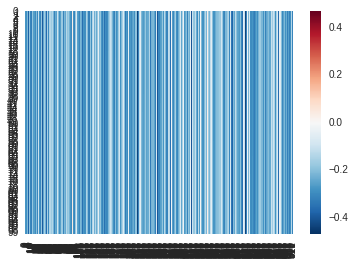

In [12]:
ab = plot_tensor(outs,5)

In [13]:
print(np.var(ab[:,5]))
print(np.mean(ab[:,1]))
print(np.var(ab[0]))
print(np.mean(ab[0]))

1.96629e-06
-0.276341
0.00688658
-0.221356


In [14]:
## plotting for average over time for all dimensions of the hidden variables
plt.plot([np.var(ab[:,i]) for i in range(ab.shape[1])])

NameError: name 'plt' is not defined

In [ ]:
## plotting variance over hidden units over each time step
plt.plot([np.mean(ab[i,:]) for i in range(ab.shape[0])])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist_loss)

In [ ]:
outs[0].shape